August: Animations of the vertical velocity (W) profiles at different depths using pcolormesh and contour lines.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

import warnings
warnings.filterwarnings("ignore")

In [9]:
import importlib
importlib.reload(general_functions)

<module 'general_functions' from '/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/general_functions.py'>

In [3]:
def get_vars(dirname, depth_ind):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    filesU = general_functions.get_files(dirname, fname, 'grid_U') 
    filesW = general_functions.get_files(dirname, fname, 'grid_W')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU, scDataset(filesW) as dsW:
        deptht = dsT.variables['deptht'][depth_ind]
        sozotaux = dsU.variables['sozotaux'][:,0,0]        
        vovecrtz0 = dsW.variables['vovecrtz'][:,depth_ind,y,x]
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0,depth_ind,y,x]
        
    tmask = np.tile(tmask0, (len(sozotaux),1, 1))  
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    vovecrtz_cm = vovecrtz[:] * 100
    
    return vovecrtz_cm, sozotaux, deptht

In [4]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'

vovecrtzA, sozotaux, depthtA = get_vars(dirname, 7)
vovecrtzB, sozotaux, depthtB = get_vars(dirname, 9)
vovecrtzC, sozotaux, depthtC = get_vars(dirname, 11)

print(depthtA, depthtB, depthtC)

65.625 83.125 100.625


In [10]:
def init():
    for var_array, ax in zip ([vovecrtzA, vovecrtzB, vovecrtzC], [ax1, ax2, ax3]):
        vel = var_array[0,...]
        ax, xs, ys = general_functions.set_xy(ax, var_array)
        cs = ax.contour(xs, ys, vel, levels = levels, colors='k')
    return cs,

# ------------------------------------------------------------------------------------

def animate(time_ind):
    ax1.cla(); ax2.cla(); ax3.cla()
    
    for ax, var_array, depm in zip ([ax1, ax2, ax3], [vovecrtzA, vovecrtzB, vovecrtzC], [depthtA, depthtB, depthtC]):
        
        ax = general_functions.set_plots_after_clear(ax, 'W Velocity [cm s$^{-1}$]    dep[m]=', depm, 'top')
        vel = var_array[time_ind,...]
        ax, xs, ys = general_functions.set_xy(ax, vel)
        
        cs = ax.contour(xs, ys, vel, levels = levels, colors='k')
        ax.clabel(cs, inline=1, fontsize=10)
        
        cmap = plt.get_cmap(cm.RdBu_r)
        cmap.set_bad('wheat')
        P = ax.pcolormesh(xs, ys, vel, vmin = -1*vm, vmax = vm, cmap = cmap)
        
        if time_ind == 0:
            cbar = plt.colorbar(P, ax=ax, pad=0.1, orientation='horizontal', extend='both')
            cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=45)
        else:
            pass
        
    axa.plot(sozotaux[:time_ind], c='#384e72', linewidth=2.5)
    axa.set_xlim([0, sozotaux.shape[0]])
    axa.set_ylim(sozotaux.min(), sozotaux.max())
    return cs,

[-0.1, -0.06, -0.02, 0.02, 0.06, 0.1]


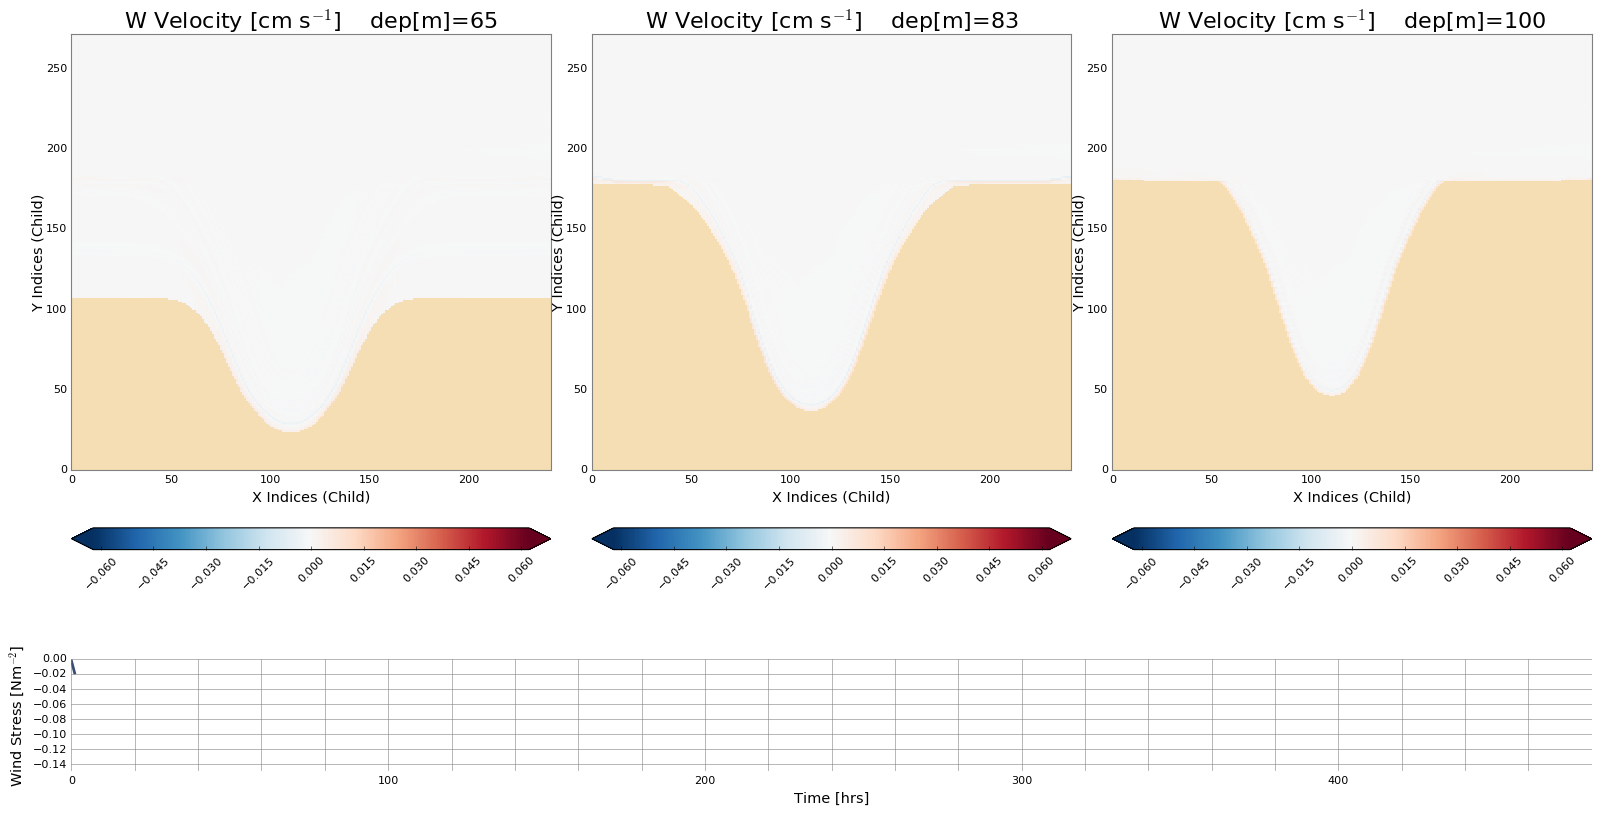

In [11]:
fig = plt.figure(figsize=(20, 12))
ax1 = plt.subplot2grid((6, 12), (0, 0), colspan=4, rowspan=4)
ax2 = plt.subplot2grid((6, 12), (0, 4), colspan=4, rowspan=4, sharey=ax1)
ax3 = plt.subplot2grid((6, 12), (0, 8), colspan=4, rowspan=4, sharey=ax1)
axa = plt.subplot2grid((6, 12), (4, 0), colspan=12)

axes = [ax1, ax2, ax3]
fig, axes, axa = general_functions.set_plots(fig, axes, axa)
vm, levels = general_functions.get_limits(vovecrtzA, vovecrtzB, vovecrtzC, 0.4, 6)

print(levels)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=3, bitrate=1000000, codec="libx264")
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=3)
anim.save('uvw.mp4', writer=writer)